6 Task.

 1. Choose 3-4 regression models (e.g., LightGBM, XGBoost) and train them to predict “Gap” target variable on default parameters (use 10-fold cross-validation)
Note: every model has use example on scikit-learn.org

2. Visualize the results via R2 plot (predicted vs. real), compare the models’ performance and training speed

3. Optimize the best-performing model using hyperparameters tuning (grid search)


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 1.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
df1 = pd.read_csv('normal_data.csv')
df1

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,u0,u298,h298,g298,cv
0,gdb_109095,CCC1=CC=CCCC1,0.449282,0.330141,0.243678,0.037569,0.764274,0.624945,0.569449,0.382952,0.370827,0.724906,0.774598,0.774601,0.774601,0.774592,0.566309
1,gdb_126739,CCn1ccc(n1)OC,0.473040,0.348638,0.246181,0.106963,0.525791,0.603349,0.734991,0.513995,0.336688,0.524731,0.579559,0.579562,0.579562,0.579554,0.474798
2,gdb_61921,CC(NCC#N)C1CN1,0.500983,0.187295,0.141656,0.271499,0.539178,0.423094,0.695915,0.590076,0.478414,0.570401,0.636682,0.636687,0.636687,0.636672,0.568595
3,gdb_17599,CC(=O)C(=O)N1CC1,0.675234,0.604947,0.409472,0.071024,0.318414,0.459674,0.383304,0.345038,0.157619,0.343490,0.635213,0.635214,0.635214,0.635210,0.317462
4,gdb_94340,OC1CCC11CC1C#C,0.340981,0.433356,0.348863,0.112827,0.564247,0.478625,0.790409,0.625700,0.258289,0.515049,0.675286,0.675289,0.675289,0.675283,0.544768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18092,gdb_50348,O=CC1OC2CCC1O2,0.432257,0.577848,0.562103,0.124272,0.356477,0.398413,0.498757,0.463104,0.139983,0.430434,0.465630,0.465627,0.465627,0.465633,0.265584
18093,gdb_108076,OCC12OC3CC1(O)C23,0.364586,0.637437,0.464532,0.051101,0.358315,0.522697,0.802487,0.608906,0.161493,0.422223,0.465895,0.465893,0.465893,0.465897,0.388826
18094,gdb_29605,Cc1cocc1NC=O,0.432295,0.435365,0.261867,0.228947,0.445728,0.585721,0.630906,0.449618,0.272126,0.377069,0.525917,0.525917,0.525917,0.525915,0.381504
18095,gdb_86262,CC1CC(C)C1(C)C#N,0.113004,0.599649,0.373505,0.225224,0.613860,0.230498,0.743872,0.735623,0.279115,0.664926,0.728583,0.728588,0.728588,0.728578,0.660997


In [5]:
df = pd.read_csv('pca_data.csv', index_col=0)

In [6]:
df

,1,2,3,4,5
0,,,,,
0.397521,-0.026781,0.106852,-0.450818,-0.159609,-0.089252
0.147343,-0.144298,-0.001357,-0.006095,-0.152672,0.016706
0.333801,-0.307708,0.045246,-0.079888,0.081616,0.150841
-0.354433,0.009432,0.263569,-0.170578,0.011204,-0.134969
0.241966,0.102004,-0.062532,-0.051126,0.023555,0.041869
...,...,...,...,...,...
-0.395285,0.016151,-0.084607,0.090350,0.020161,-0.128519
-0.168929,0.113777,-0.186910,0.273971,-0.100100,-0.063314
-0.134581,-0.161350,-0.047517,-0.012423,-0.124980,0.112129


# Х - это набор признаков (иногда называемый матрицей признаков), который содержит данные, на основе которых модель будет делать прогнозы

# у -искомое **gap**

test_size=0.2 - это параметр, который указывает размер тестового набора. В данном случае он равен 20%, что означает, что *20% данных будет выделено для тестирования*, а остальные 80% будут использоваться для обучения.

***random_state=38*** - это параметр, который устанавливает случайное состояние, чтобы результаты можно было воспроизвести

In [7]:
X = df
y = df1['gap']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

 словарь *models*, в котором ключи представляют собой названия моделей, а значения - экземпляры регрессоров для каждой модели

In [8]:
models = {
    'xgb': XGBRegressor(),
    'rf': RandomForestRegressor(),
    'catboost': CatBoostRegressor()
}

*n_splits=10*: Это количество разбиений (или фолдов) данных. В данном случае данные будут разделены на 10 фолдов.

*shuffle=True*: Этот параметр указывает, следует ли предварительно перемешать данные перед разделением. В данном случае данные будут перемешаны.

In [9]:
kfold = KFold(n_splits=10, shuffle=True, random_state=38)

ф-ция принимает модель, данные, объект разделения для кросс-валидации (kfold), а также оценочную метрику R^2

In [10]:
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    results[name] = scores.mean()

for name, score in results.items():
    print(f'{name}: R^2 = {score:.4f}')

Выходные данные были обрезаны до нескольких последних строк (5000).
7:	learn: 0.0978900	total: 31.1ms	remaining: 3.85s
8:	learn: 0.0959238	total: 36ms	remaining: 3.96s
9:	learn: 0.0941674	total: 39.7ms	remaining: 3.93s
10:	learn: 0.0925777	total: 43.4ms	remaining: 3.9s
11:	learn: 0.0909882	total: 47.1ms	remaining: 3.88s
12:	learn: 0.0896074	total: 50.8ms	remaining: 3.86s
13:	learn: 0.0883711	total: 54.4ms	remaining: 3.83s
14:	learn: 0.0872412	total: 58.1ms	remaining: 3.82s
15:	learn: 0.0861254	total: 62.2ms	remaining: 3.82s
16:	learn: 0.0851642	total: 65.7ms	remaining: 3.8s
17:	learn: 0.0842981	total: 69.2ms	remaining: 3.77s
18:	learn: 0.0834582	total: 73.1ms	remaining: 3.77s
19:	learn: 0.0827163	total: 78.6ms	remaining: 3.85s
20:	learn: 0.0820447	total: 82.2ms	remaining: 3.83s
21:	learn: 0.0814064	total: 85.8ms	remaining: 3.82s
22:	learn: 0.0807558	total: 89.5ms	remaining: 3.8s
23:	learn: 0.0801137	total: 93.2ms	remaining: 3.79s
24:	learn: 0.0795891	total: 96.7ms	remaining: 3.77s
25:	

отобразить только средние значения R^2, игнорируя стандартные отклонения

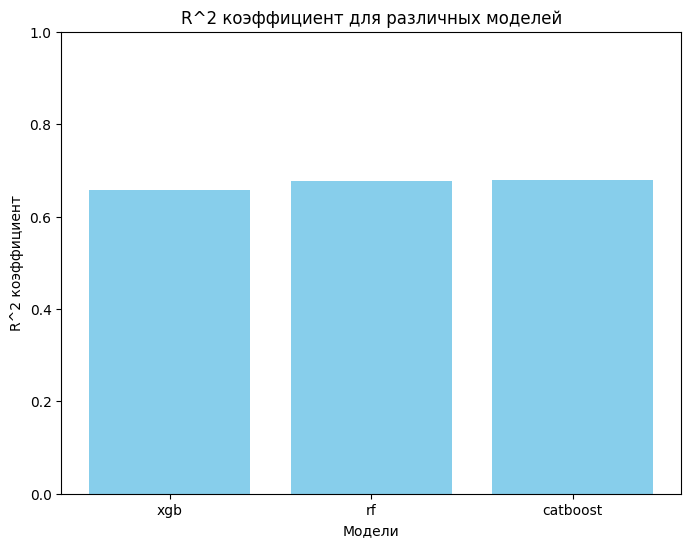

In [11]:
plt.figure(figsize=(8, 6))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.xlabel('Модели')
plt.ylabel('R^2 коэффициент')
plt.title('R^2 коэффициент для различных моделей')
plt.ylim(0, 1)
plt.show()

модель CatBoostRegressor для обучения на обучающих данных (X_train и y_train) и получения прогнозов на тестовых данных (X_test)

 коэффициент детерминации R^2 для оценки качества модели на тестовых данных

 Коэффициент R^2 измеряет, насколько хорошо ваша модель объясняет изменчивость целевой переменной и принимает значения от 0 до 1, где 1 означает идеальное предсказание, а 0 - отсутствие предсказательной силы.

In [12]:
model = CatBoostRegressor()

model.fit(X_train,
          y_train
          )
y_pred = model.predict(X_test)

r2_initial = r2_score(y_test,
                      y_pred)

Learning rate set to 0.062455
0:	learn: 0.1169589	total: 21.6ms	remaining: 21.6s
1:	learn: 0.1135273	total: 35.7ms	remaining: 17.8s
2:	learn: 0.1104342	total: 57.1ms	remaining: 19s
3:	learn: 0.1076112	total: 86.7ms	remaining: 21.6s
4:	learn: 0.1049630	total: 120ms	remaining: 23.9s
5:	learn: 0.1024992	total: 149ms	remaining: 24.7s
6:	learn: 0.1002388	total: 164ms	remaining: 23.3s
7:	learn: 0.0981555	total: 191ms	remaining: 23.6s
8:	learn: 0.0961574	total: 216ms	remaining: 23.8s
9:	learn: 0.0944121	total: 233ms	remaining: 23s
10:	learn: 0.0928087	total: 257ms	remaining: 23.1s
11:	learn: 0.0913114	total: 266ms	remaining: 21.9s
12:	learn: 0.0899498	total: 269ms	remaining: 20.4s
13:	learn: 0.0886948	total: 280ms	remaining: 19.7s
14:	learn: 0.0875473	total: 290ms	remaining: 19.1s
15:	learn: 0.0864703	total: 300ms	remaining: 18.5s
16:	learn: 0.0854684	total: 310ms	remaining: 17.9s
17:	learn: 0.0845843	total: 318ms	remaining: 17.3s
18:	learn: 0.0837272	total: 327ms	remaining: 16.9s
19:	learn: 

поиск оптимальных гиперпараметров для модели CatBoostRegressor с использованием метода кросс-валидации GridSearchCV

In [13]:
param_grid = {'l2_leaf_reg':[4],
              'learning_rate':[0.1],
              'depth':[8],
              'iterations':[2000]
}
model = CatBoostRegressor()

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=3,
                    scoring='neg_root_mean_squared_error',
                    verbose=0
                    ) # 3-fold cross-validation is used for faster estimation of parameters combinations

grid.fit(X_train,
         y_train
         )
grid.best_params_

Выходные данные были обрезаны до нескольких последних строк (5000).
1000:	learn: 0.0406795	total: 6.39s	remaining: 6.38s
1001:	learn: 0.0406663	total: 6.41s	remaining: 6.38s
1002:	learn: 0.0406470	total: 6.41s	remaining: 6.38s
1003:	learn: 0.0406354	total: 6.42s	remaining: 6.37s
1004:	learn: 0.0406086	total: 6.43s	remaining: 6.37s
1005:	learn: 0.0405910	total: 6.44s	remaining: 6.36s
1006:	learn: 0.0405707	total: 6.45s	remaining: 6.36s
1007:	learn: 0.0405572	total: 6.46s	remaining: 6.35s
1008:	learn: 0.0405323	total: 6.47s	remaining: 6.36s
1009:	learn: 0.0405153	total: 6.48s	remaining: 6.35s
1010:	learn: 0.0404965	total: 6.48s	remaining: 6.34s
1011:	learn: 0.0404711	total: 6.49s	remaining: 6.34s
1012:	learn: 0.0404523	total: 6.5s	remaining: 6.33s
1013:	learn: 0.0404385	total: 6.51s	remaining: 6.33s
1014:	learn: 0.0404188	total: 6.52s	remaining: 6.33s
1015:	learn: 0.0403941	total: 6.53s	remaining: 6.33s
1016:	learn: 0.0403722	total: 6.54s	remaining: 6.32s
1017:	learn: 0.0403598	total: 6.

{'depth': 8, 'iterations': 2000, 'l2_leaf_reg': 4, 'learning_rate': 0.1}

Для сохранения оптимальных гиперпараметров модели для последующего использования при анализе и сравнении моделей

In [14]:
optimized_model = grid.best_estimator_ # We take the best hyperparameters set for later use
y_pred_optimized = optimized_model.predict(X_test)
r2_optimized = r2_score(y_test,
                        y_pred_optimized
                        )

Графики для визуализации производительности моделей

Линия k-- представляет идеальное соответствие между фактическими и предсказанными значениями. Текст на графиках показывает коэффициент детерминации ($R^2$), который указывает на качество соответствия модели данным

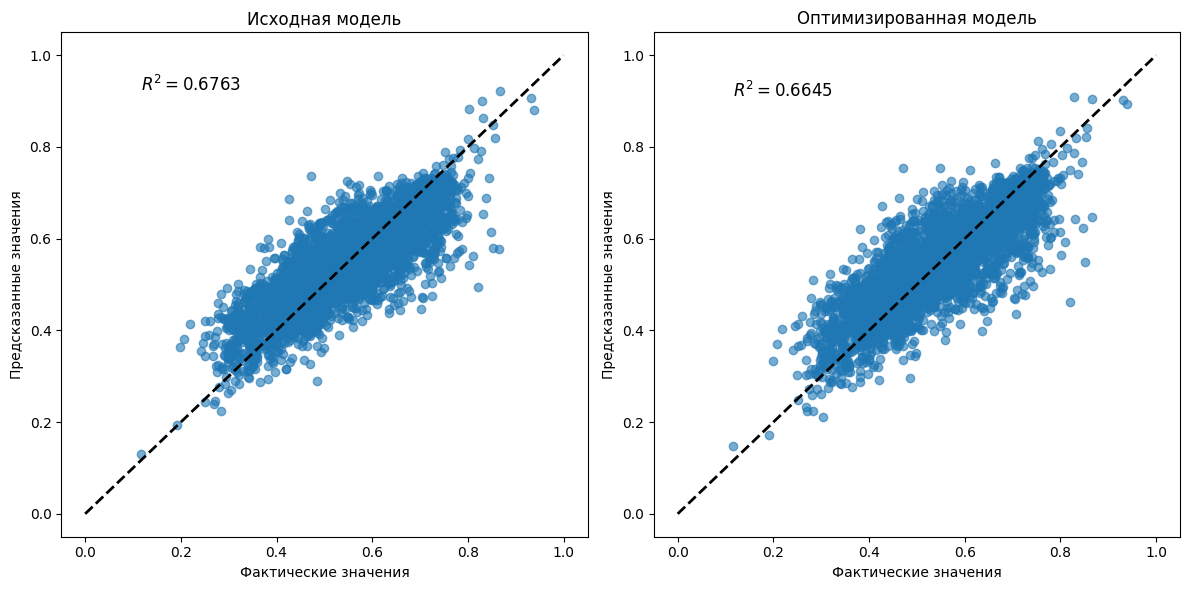

In [15]:
plt.figure(figsize=(12, 6))

# Визуализация производительности исходной модели
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6)  # Точечный график фактических и предсказанных значений
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Идеальное соответствие
plt.xlabel('Фактические значения')  # Подпись оси x
plt.ylabel('Предсказанные значения')  # Подпись оси y
plt.title(f'Исходная модель')  # Заголовок
plt.text(np.min(y_test), np.max(y_pred), f'$R^2={r2_initial:.4f}$', fontsize=12)  # Коэффициент детерминации

# Визуализация производительности оптимизированной модели
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_optimized, alpha=0.6)  # Точечный график фактических и предсказанных значений
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Идеальное соответствие
plt.xlabel('Фактические значения')  # Подпись оси x
plt.ylabel('Предсказанные значения')  # Подпись оси y
plt.title(f'Оптимизированная модель')  # Заголовок
plt.text(np.min(y_test), np.max(y_pred_optimized), f'$R^2={r2_optimized:.4f}$', fontsize=12)  # Коэффициент детерминации

plt.tight_layout()  # Автоматическое выравнивание графиков
plt.show()
